# Introduction

This ipython notebook is used for a regionalization analysis of opioid risk environments in Chicago.

We proceed in a few steps.

1. Data Preprocessing -- spatial aggregation, splitting our data into our environments
2. Clustering -- creating a large amount of clusters and picking the best.
3. Validation -- comparing the distribution of our clusters to narcotic arrest rates as a basic validation.

## Data Preprocessing

We want to make a big dataset of tract level data which we then split into three smaller datasets. To do so, we need to do some point in polygon analyses, merge a lot of things together, and then split everything up. We do so in steps.

In [1]:
import pygris
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt # for debugging

#### Load data

In [2]:
# Point data
streetview = pd.read_csv('../data/streetview_greenery.csv')
streetview = gpd.GeoDataFrame(streetview, 
                geometry=gpd.points_from_xy(streetview.longitude, streetview.latitude), 
                crs='EPSG:4326').to_crs('EPSG:26916')

threeoneone = pd.read_csv('../data/311reqs.csv')
violent_crime = pd.read_csv('../data/violent_crime2023.csv')
narcotic_crime = pd.read_csv('../data/narcotic_crime2023.csv')

# Get Chicago tracts
chicago_boundaries = gpd.read_file('../data/shapes/chicago_boundaries.geojson').to_crs('EPSG:26916')
tracts = pygris.tracts(cb=True, county='cook', state='il')[['GEOID', 'geometry']].to_crs("EPSG:26916")

relevant_geoids = gpd\
    .sjoin( 
        chicago_boundaries.to_crs('EPSG:26916'),
        gpd.GeoDataFrame(
            tracts.drop('geometry', axis=1), 
            geometry=tracts.centroid, 
            crs='EPSG:26916'
        ),
        predicate='contains'
        )['GEOID']

tracts = tracts[tracts['GEOID'].isin(relevant_geoids)]

# Attribute data
census = pd.read_csv('../data/censusdata.csv')
svi = pd.read_csv('../data/illinois_svi_2022.csv')\
    [['FIPS', 'RPL_THEMES']]\
    .rename({'FIPS':'GEOID'}, axis=1)

hospital_access = pd.read_csv('../data/access/hospital_access.csv')
mh_access = pd.read_csv('../data/access/mh_access.csv')
moud_access = pd.read_csv('../data/access/moud_access.csv')
otp_access = pd.read_csv('../data/access/otp_access.csv')

Using the default year of 2021
Using FIPS code '17' for input 'il'
Using FIPS code '031' for input 'cook'


C:\Users\wimer\AppData\Local\Temp\ipykernel_13692\1268301531.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  moud_access = pd.read_csv('../data/access/moud_access.csv')


#### Aggregate Data to Tract Level

In [3]:
streetview = streetview\
            .sjoin(tracts)\
            [['GEOID', 'absolute_greenery']]\
            .groupby('GEOID')\
            .sum()\
            .reset_index()

streetview['relative_greenery'] = (streetview['absolute_greenery'] - streetview['absolute_greenery'].min())/(streetview['absolute_greenery'].max() - streetview['absolute_greenery'].min())

streetview = streetview[['GEOID', 'relative_greenery']]
streetview.head()

,GEOID,relative_greenery
0,17031010100,0.078086
1,17031010201,0.151005
2,17031010202,0.083967
3,17031010300,0.098833
4,17031010400,0.035330


In [4]:
threeoneone = threeoneone[['GEOID', 'disorder_class']]\
                .value_counts()\
                .reset_index()
physical311 = threeoneone[threeoneone['disorder_class'] == 'PHYSICAL']\
                .drop('disorder_class', axis=1)\
                .rename({'count':'physical_311s'}, axis=1)
social311   = threeoneone[threeoneone['disorder_class'] == 'SOCIAL'  ]\
                .drop('disorder_class', axis=1)\
                .rename({'count':'social_311s'}, axis=1)
economic311 = threeoneone[threeoneone['disorder_class'] == 'ECONOMIC']\
                .drop('disorder_class', axis=1)\
                .rename({'count':'economic_311s'}, axis=1)

In [5]:
economic311.head()

,GEOID,economic_311s
1198,17031839100,165
1253,17031081800,143
1294,17031060900,130
1345,17031320102,114
1349,17031833000,113


In [6]:
violent_crime['violent_crime_count'] = 1
violent_crime = violent_crime[['GEOID', 'violent_crime_count']].groupby('GEOID').sum('i').reset_index()
violent_crime.head()

,GEOID,violent_crime_count
0,17031010100,179
1,17031010201,130
2,17031010202,180
3,17031010300,162
4,17031010400,87


In [7]:
narcotic_crime['narcotic_crime_count'] = 1
narcotic_crime = narcotic_crime[['GEOID', 'narcotic_crime_count']].groupby('GEOID').sum('i').reset_index()
narcotic_crime.head()

,GEOID,narcotic_crime_count
0,17031010100,13
1,17031010201,3
2,17031010202,20
3,17031010300,4
4,17031010400,3


In [8]:
hospital_access = hospital_access[['GEOID', 'minDisHosp']]
hospital_access.head()

,GEOID,minDisHosp
0,28075000300,1.33
1,28075000600,1.30
2,28077960100,6.12
3,28081950301,7.13
4,28085950600,1.90


In [9]:
moud_access = moud_access[['GEOID', 'metMinDis', 'bupMinDis']]
moud_access.head()

,GEOID,metMinDis,bupMinDis
0,28075000300,1.581588,1.571650
1,28075000600,1.022112,1.456406
2,28077960100,60.160346,10.691173
3,28081950301,44.448542,7.659164
4,28085950600,64.867888,1.629512


In [10]:
otp_access = otp_access[['GEOID', 'minDist_OTP']]
otp_access.head()

,GEOID,minDist_OTP
0,28075000300,1.33
1,28075000600,0.87
2,28077960100,51.15
3,28081950301,36.56
4,28085950600,56.22


In [11]:
mh_access = mh_access[['GEOID', 'minDisMH']]
mh_access.head()

,GEOID,minDisMH
0,28075000300,0.80
1,28075000600,1.87
2,28077960100,27.71
3,28081950301,6.84
4,28085950600,2.14


#### Big Table

In [12]:
# Standardize merge keys
census['GEOID']          = census['GEOID'].astype(str).apply(lambda x: x.split('.')[0])
physical311['GEOID']     = physical311['GEOID'].astype(str).apply(lambda x: x.split('.')[0])
economic311['GEOID']     = economic311['GEOID'].astype(str).apply(lambda x: x.split('.')[0])
social311['GEOID']       = social311['GEOID'].astype(str).apply(lambda x: x.split('.')[0])
svi['GEOID']             = svi['GEOID'].astype(str).apply(lambda x: x.split('.')[0])
violent_crime['GEOID']   = violent_crime['GEOID'].astype(str).apply(lambda x: x.split('.')[0])
narcotic_crime['GEOID']  = narcotic_crime['GEOID'].astype(str).apply(lambda x: x.split('.')[0])
hospital_access['GEOID'] = hospital_access['GEOID'].astype(str).apply(lambda x: x.split('.')[0])
moud_access['GEOID']     = moud_access['GEOID'].astype(str).apply(lambda x: x.split('.')[0])
otp_access['GEOID']      = otp_access['GEOID'].astype(str).apply(lambda x: x.split('.')[0])
mh_access['GEOID']       = mh_access['GEOID'].astype(str).apply(lambda x: x.split('.')[0])

# Merge
tract_data = census\
    .merge(streetview,      on='GEOID', how='outer')\
    .merge(physical311,     on='GEOID', how='left')\
    .merge(economic311,     on='GEOID', how='left')\
    .merge(social311,       on='GEOID', how='left')\
    .merge(svi,             on='GEOID', how='left')\
    .merge(violent_crime,   on='GEOID', how='left')\
    .merge(narcotic_crime,  on='GEOID', how='left')\
    .merge(hospital_access, on='GEOID', how='left')\
    .merge(moud_access,     on='GEOID', how='left')\
    .merge(otp_access,      on='GEOID', how='left')\
    .merge(mh_access,       on='GEOID', how='left')\
    .merge(tracts,          on='GEOID', how='inner')

# Clean out unneeeded datasets
del census, physical311, economic311, social311, svi, violent_crime, narcotic_crime, hospital_access, moud_access, otp_access, mh_access, tracts

tract_data[['relative_greenery', 'violent_crime_count', 'narcotic_crime_count', 'economic_311s', 'social_311s', 'physical_311s']].fillna(0, inplace=True)

for col in ['violent_crime_count', 'narcotic_crime_count', 'economic_311s', 'social_311s', 'physical_311s']:
    tract_data[col] = 1000 * tract_data[col] / tract_data['TotalPopulation']

tract_data.rename({
    'violent_crime_count':'violent_crime_rate',
    'narcotic_crime_count':'narcotic_crime_rate'
    }, axis=1, inplace=1)

tract_data.head()

C:\Users\wimer\AppData\Local\Temp\ipykernel_13692\2746950062.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_data[['relative_greenery', 'violent_crime_count', 'narcotic_crime_count', 'economic_311s', 'social_311s', 'physical_311s']].fillna(0, inplace=True)


,GEOID,TotalPopulation,WhiteP,BlackP,AsianP,HispP,18to24P,Ovr65P,MHSdP,MedInc,...,social_311s,RPL_THEMES,violent_crime_rate,narcotic_crime_rate,minDisHosp,metMinDis,bupMinDis,minDist_OTP,minDisMH,geometry
0,17031010100,4284.0,44.701214,32.119514,2.194211,21.475257,15.989729,12.861811,22.619048,36610.0,...,26.610644,0.8504,41.783380,3.034547,1.03,1.151533,0.177770,0.86,1.00,"POLYGON ((443936.001 4652545.254, 444376.060 4..."
1,17031010201,8210.0,25.420219,36.650426,3.629720,24.397077,11.412911,9.001218,40.651907,35407.0,...,31.912302,0.9343,15.834348,0.365408,0.84,0.575462,0.563450,0.43,0.85,"POLYGON ((443315.826 4652166.333, 443663.936 4..."
2,17031010202,2865.0,31.134380,32.984293,10.890052,19.406632,10.855148,13.438045,30.828890,29590.0,...,54.799302,0.9545,62.827225,6.980803,1.10,0.995552,0.343353,0.74,0.74,"POLYGON ((443961.380 4652152.982, 444254.861 4..."
3,17031010300,6237.0,53.599487,23.617124,5.419272,16.931217,8.866442,24.338624,25.777001,37530.0,...,39.121372,0.8132,25.974026,0.641334,1.48,1.446811,0.448845,1.08,0.52,"POLYGON ((444418.780 4652145.271, 444570.448 4..."
4,17031010400,4473.0,79.991057,7.914152,4.761905,8.450704,37.916387,7.780013,8.151766,34095.0,...,35.546613,0.3644,19.450034,0.670691,2.54,2.369086,0.563062,1.76,0.70,"POLYGON ((445065.309 4651413.606, 445241.499 4..."


In [13]:
social_cols = ['GEOID', 'social_311s', 'MHSdP', 'RPL_THEMES', 'violent_crime_rate', 'WhiteP', 'BlackP', 'AsianP', 'HispP', '18to24P', 'Ovr65P', 'geometry']
econ_cols = ['GEOID', 'economic_311s', 'MedInc', 'PovP', 'Unemployment', 'HighRiskJobP', 'NoIntP', 'geometry']
physical_cols = ['GEOID', 'physical_311s', 'relative_greenery', 'VacantP', 'geometry'] # lol
policy_cols = ['GEOID', 'minDisHosp', 'metMinDis', 'bupMinDis', 'minDist_OTP', 'minDisMH', 'geometry']

social = tract_data[social_cols].dropna()
econ = tract_data[econ_cols].dropna()
physical = tract_data[physical_cols].dropna()
policy = tract_data[policy_cols].dropna()

social.head()

,GEOID,social_311s,MHSdP,RPL_THEMES,violent_crime_rate,WhiteP,BlackP,AsianP,HispP,18to24P,Ovr65P,geometry
0,17031010100,26.610644,22.619048,0.8504,41.783380,44.701214,32.119514,2.194211,21.475257,15.989729,12.861811,"POLYGON ((443936.001 4652545.254, 444376.060 4..."
1,17031010201,31.912302,40.651907,0.9343,15.834348,25.420219,36.650426,3.629720,24.397077,11.412911,9.001218,"POLYGON ((443315.826 4652166.333, 443663.936 4..."
2,17031010202,54.799302,30.828890,0.9545,62.827225,31.134380,32.984293,10.890052,19.406632,10.855148,13.438045,"POLYGON ((443961.380 4652152.982, 444254.861 4..."
3,17031010300,39.121372,25.777001,0.8132,25.974026,53.599487,23.617124,5.419272,16.931217,8.866442,24.338624,"POLYGON ((444418.780 4652145.271, 444570.448 4..."
4,17031010400,35.546613,8.151766,0.3644,19.450034,79.991057,7.914152,4.761905,8.450704,37.916387,7.780013,"POLYGON ((445065.309 4651413.606, 445241.499 4..."


In [14]:
policy.head()

,GEOID,minDisHosp,metMinDis,bupMinDis,minDist_OTP,minDisMH,geometry
0,17031010100,1.03,1.151533,0.177770,0.86,1.00,"POLYGON ((443936.001 4652545.254, 444376.060 4..."
1,17031010201,0.84,0.575462,0.563450,0.43,0.85,"POLYGON ((443315.826 4652166.333, 443663.936 4..."
2,17031010202,1.10,0.995552,0.343353,0.74,0.74,"POLYGON ((443961.380 4652152.982, 444254.861 4..."
3,17031010300,1.48,1.446811,0.448845,1.08,0.52,"POLYGON ((444418.780 4652145.271, 444570.448 4..."
4,17031010400,2.54,2.369086,0.563062,1.76,0.70,"POLYGON ((445065.309 4651413.606, 445241.499 4..."


In [15]:
physical.head()

,GEOID,physical_311s,relative_greenery,VacantP,geometry
0,17031010100,93.604108,0.078086,21.074099,"POLYGON ((443936.001 4652545.254, 444376.060 4..."
1,17031010201,98.172960,0.151005,7.682927,"POLYGON ((443315.826 4652166.333, 443663.936 4..."
2,17031010202,126.352531,0.083967,7.207891,"POLYGON ((443961.380 4652152.982, 444254.861 4..."
3,17031010300,92.833093,0.098833,8.222892,"POLYGON ((444418.780 4652145.271, 444570.448 4..."
4,17031010400,82.494970,0.035330,14.142678,"POLYGON ((445065.309 4651413.606, 445241.499 4..."


In [16]:
econ.head()

,GEOID,economic_311s,MedInc,PovP,Unemployment,HighRiskJobP,NoIntP,geometry
0,17031010100,1.633987,36610.0,18.678526,9.769154,9.421922,7.795004,"POLYGON ((443936.001 4652545.254, 444376.060 4..."
1,17031010201,1.218027,35407.0,28.177833,4.088542,16.481994,9.775429,"POLYGON ((443315.826 4652166.333, 443663.936 4..."
2,17031010202,2.443281,29590.0,22.928709,8.914209,12.734082,6.541292,"POLYGON ((443961.380 4652152.982, 444254.861 4..."
3,17031010300,3.527337,37530.0,2.235099,4.030656,14.699793,7.712504,"POLYGON ((444418.780 4652145.271, 444570.448 4..."
4,17031010400,3.129890,34095.0,5.737705,3.200000,9.866667,14.285714,"POLYGON ((445065.309 4651413.606, 445241.499 4..."


### Intermediate Data Processing

We are going to conduct quite a few analyses with our data, so we conduct a few more cleaning steps. First, we apply a standard scaler to all variables, then we attempt to construct PCAs from our variables.

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

In [19]:
scaler = StandardScaler()

def scale_variables(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Takes in a python geodataframe and returns a dataframe with scaled numeric variables
    '''
    scaler = StandardScaler()
    
    df2 = pd.DataFrame(scaler.fit_transform(df.drop(['GEOID', 'geometry'], axis=1)), 
                         columns=df.drop(['GEOID', 'geometry'], axis=1).columns,
                         index=df.index)
    df2['GEOID'] = df.GEOID
    df2['geometry'] = df.geometry

    return gpd.GeoDataFrame(df2, geometry=df2.geometry, crs='EPSG:26916')

social = scale_variables(social).set_index('GEOID')
econ = scale_variables(econ).set_index('GEOID')
physical = scale_variables(physical).set_index('GEOID')
policy = scale_variables(policy).set_index('GEOID')

In [20]:
social.head()

,social_311s,MHSdP,RPL_THEMES,violent_crime_rate,WhiteP,BlackP,AsianP,HispP,18to24P,Ovr65P,geometry
GEOID,,,,,,,,,,,
17031010100,-0.865327,-0.677712,0.721651,0.210791,0.188288,-0.057852,-0.410498,-0.186004,0.868789,-0.100419,"POLYGON ((443936.001 4652545.254, 444376.060 4..."
17031010201,-0.759014,0.183588,1.010830,-0.645021,-0.477211,0.060775,-0.264626,-0.081430,0.212193,-0.638830,"POLYGON ((443315.826 4652166.333, 443663.936 4..."
17031010202,-0.300063,-0.285587,1.080454,0.904827,-0.279982,-0.035210,0.473148,-0.260042,0.132175,-0.020055,"POLYGON ((443961.380 4652152.982, 444254.861 4..."
17031010300,-0.614451,-0.526879,0.593433,-0.310609,0.495419,-0.280459,-0.082777,-0.348639,-0.153127,1.500174,"POLYGON ((444418.780 4652145.271, 444570.448 4..."
17031010400,-0.686135,-1.368710,-0.953451,-0.525774,1.406344,-0.691589,-0.149576,-0.652163,4.014415,-0.809143,"POLYGON ((445065.309 4651413.606, 445241.499 4..."


We attempt to create principal components within our environments, with the aim of reducing dimensionality. We only keep the components if they satisfy three conditions:

1. They capture at least 80% of the variance.
2. The split agrees with the elbow rule.
3. The resultant components are nameable.

We first create our PCAs to see if any satisfy these requirements. If any do, we then go through the extra effort to keep them.

In [26]:
# Make PCAs
socpca = PCA()
ecopca = PCA()
phypca = PCA()
polpca = PCA()

soc_pca = socpca.fit_transform(social.drop(['geometry'], axis=1))
eco_pca = ecopca.fit_transform(econ.drop(['geometry'], axis=1))
phy_pca = phypca.fit_transform(physical.drop(['geometry'], axis=1))
pol_pca = polpca.fit_transform(policy.drop(['geometry'], axis=1))

Text(0.5, 1.0, 'Policy')

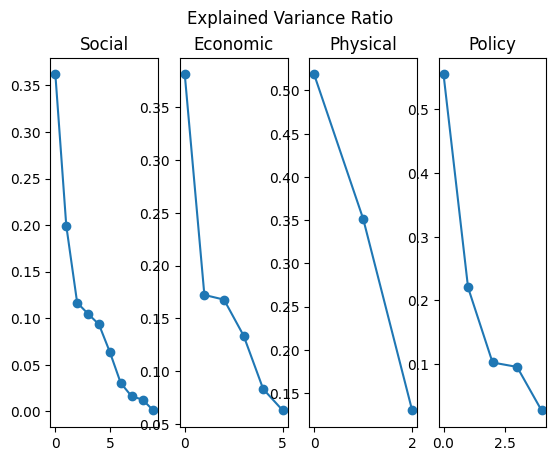

In [27]:
figs, axs = plt.subplots(1, 4)

for i, pca in enumerate([socpca, ecopca, phypca, polpca]):
    axs[i].plot(pca.explained_variance_ratio_, 'o-')

figs.suptitle('Explained Variance Ratio')
axs[0].set_title('Social')
axs[1].set_title('Economic')
axs[2].set_title('Physical')
axs[3].set_title('Policy')

Text(0.5, 1.0, 'Policy')

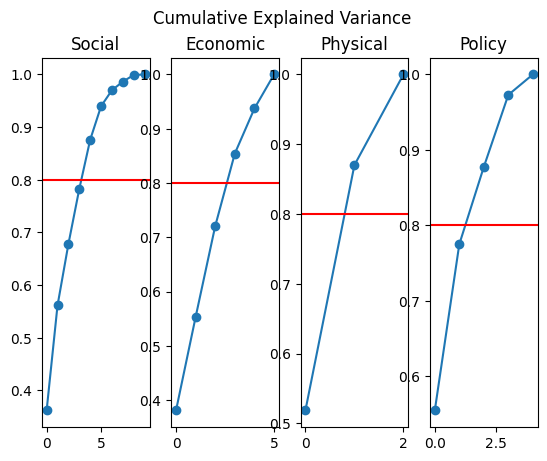

In [29]:
figs, axs = plt.subplots(1, 4)

for i, pca in enumerate([socpca, ecopca, phypca, polpca]):
    axs[i].plot(pca.explained_variance_ratio_.cumsum(), 'o-')
    axs[i].axhline(y=.8, color='red')

figs.suptitle('Cumulative Explained Variance')
axs[0].set_title('Social')
axs[1].set_title('Economic')
axs[2].set_title('Physical')
axs[3].set_title('Policy')

Based on these plots, Social with 6 and Policy with 3 are options. Economic would take 5 to satisfy the elbow rule, making it less worthwile, and physical never satisfies the elbow rule. Let's check their interpretability:

In [35]:
def make_comp_df(pca_obj, features, n_comps):
    '''
    Given a pca_obj, the list of features that the pca_obj transformed,
    and the number of components the user desires to keep, create a nicely
    transformed version of the pca_obj.
    '''
    return pd.DataFrame(
        {f'pca{i+1}':np.round(pca_obj.components_[i], 3) for i in range(n_comps)},
        index=features
    )

make_comp_df(socpca, social.drop('geometry', axis=1).columns, 6).T

,social_311s,MHSdP,RPL_THEMES,violent_crime_rate,WhiteP,BlackP,AsianP,HispP,18to24P,Ovr65P
pca1,0.042,0.370,0.436,0.395,-0.489,0.439,-0.210,-0.021,-0.045,0.191
pca2,0.385,0.436,0.213,-0.155,0.054,-0.348,-0.034,0.674,0.006,-0.115
pca3,0.130,-0.075,-0.066,0.236,-0.064,0.100,-0.174,-0.019,0.671,-0.650
pca4,-0.426,0.138,0.295,-0.207,-0.119,-0.078,0.561,0.041,0.541,0.201
pca5,0.653,-0.090,-0.019,0.313,-0.049,-0.034,0.646,-0.207,-0.026,0.062
pca6,0.269,-0.065,-0.185,0.071,0.192,-0.052,-0.350,0.016,0.499,0.688


Looking through these, they are nameable, but not clearly in a way that is useful (e.g. PCA5, which is higher for areas which are predominately Asian, feature a large number of 311s, or have violent crime), so we decline to use these PCAs.

In [36]:
make_comp_df(ecopca, econ.drop('geometry', axis=1).columns, 3).T

,economic_311s,MedInc,PovP,Unemployment,HighRiskJobP,NoIntP
pca1,0.067,0.029,0.527,0.539,0.391,0.523
pca2,-0.480,-0.847,0.179,0.076,-0.095,-0.079
pca3,0.835,-0.403,0.088,0.117,-0.342,-0.039


These are also not too usefully interpretable, at least to me, so we decline to make any PCAs for this study.

In [ ]:
del socpca, ecopca, phypca, polpca, soc_pca, eco_pca, phy_pca, pol_pca

## Clustering

We now proceed to conduct regionalization analyses on our four environments. 

In [40]:
from libpysal.weights import Queen, KNN
from sklearn import cluster
from sklearn import metrics

In [46]:
social_weights = Queen.from_dataframe(social)
econ_weights = Queen.from_dataframe(econ)
physical_weights = Queen.from_dataframe(physical)
policy_weights = Queen.from_dataframe(policy)

C:\Users\wimer\AppData\Local\Temp\ipykernel_13692\1553149427.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  social_weights = Queen.from_dataframe(social)
C:\Users\wimer\AppData\Local\Temp\ipykernel_13692\1553149427.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  econ_weights = Queen.from_dataframe(econ)


C:\Users\wimer\AppData\Local\Temp\ipykernel_13692\1553149427.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  physical_weights = Queen.from_dataframe(physical)
C:\Users\wimer\AppData\Local\Temp\ipykernel_13692\1553149427.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  policy_weights = Queen.from_dataframe(policy)
c:\Python311\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 777.
  warnings.warn(message)


#### Helper Functions

In [174]:
def test_clustering(df, min_clusters=2, max_clusters=10, total_runs=11, weights=None):
    '''
    A function which attempts to find the optimal number of clusters on a given
    dataset df through repeated clustering. 
    
    Inputs:
      df (DataFrame): dataframe of values to be clustered on. All values need
        to be some variety of numeric.
      min_clusters (int): Minimum number of clusters to check (default: 2)
      max_clusters (int): Maximum number of clusters to check (default: 10)
      total_runs (int): Total number of times to run the algorithm (default: 10).
      spectral (bool): whether or not to use spectral clustering. Uses KMeans
        if False. (default: False) 
    
    Returns None, but creates and displays a plot of mean Davies Bouldin scores, 
      Calinksi Harabasz socres, Silhouette Scores, and raw scores. 
    '''
    db_scores = np.zeros((total_runs, max_clusters-min_clusters+1))
    ch_scores = np.zeros((total_runs, max_clusters-min_clusters+1))
    silhouette_scores = np.zeros((total_runs, max_clusters-min_clusters+1))

    df_nogeom = df.copy().drop('geometry', axis=1)

    # Test our cluster algorithms:
    for attempt in range(total_runs):
        for n_cluster in range(min_clusters, max_clusters+1):
            
            # Make and fit our cluster
            clusters = cluster.AgglomerativeClustering(n_clusters = n_cluster, connectivity=weights)

            clusters.fit(df_nogeom)

            # Update cluster tracking tables
            db_scores[attempt][n_cluster-min_clusters] = metrics.davies_bouldin_score(df_nogeom, clusters.labels_)
            ch_scores[attempt][n_cluster-min_clusters] = metrics.calinski_harabasz_score(df_nogeom, clusters.labels_)
            silhouette_scores[attempt][n_cluster-min_clusters] = metrics.silhouette_score(df_nogeom, clusters.labels_)
    
    # Get results of tests
    db_scores = np.array(db_scores).mean(axis=0)
    ch_scores = np.array(ch_scores).mean(axis=0)
    silhouette_scores = np.array(silhouette_scores).mean(axis=0)

    # Create the plot
    plt.style.use('Solarize_Light2')

    fig, axes = plt.subplots(2, 2)

    axes[0, 0].plot(range(min_clusters, max_clusters+1), db_scores, 'o-', color='purple')
    axes[0, 0].set(ylabel='Davies-Bouldin',
                    xticks=range(min_clusters, max_clusters+1))

    axes[0, 1].plot(range(min_clusters, max_clusters+1), ch_scores, 'o-', color='purple')
    axes[0, 1].set(ylabel='Calinski-Harabasz',
                    xticks=range(min_clusters, max_clusters+1))

    axes[1, 0].plot(range(min_clusters, max_clusters+1), silhouette_scores, 'o-', color='purple')
    axes[1, 0].set(ylabel='Silhouette',
                    xticks=range(min_clusters, max_clusters+1))

    fig.suptitle('KMeans Clustering Results')

    plt.tight_layout()

    plt.show()

def cluster_map(df, n_clusters, weights):
    '''
    Create a map of the distribution of Agglomerative clusters with a set of
    weights.
    '''
    df_nogeom = df.copy().drop('geometry', axis=1)
    clusters = cluster.AgglomerativeClustering(n_clusters = n_clusters, connectivity=weights)
    clusters.fit(df_nogeom)

    df['labels'] = clusters.labels_

    fig, ax = plt.subplots(1, figsize=(9, 9))
    
    df.plot(
        column='labels',
        categorical=True,
        legend=True,
        linewidth=0,
        ax=ax
    )

    ax.axis('off')
    plt.tight_layout()
    plt.show()

    return df

def summarize_clusters(df, label_name='labels', relevant_aggs=['count', 'mean', 'std']):
  summ = df.groupby(label_name).describe().T
  summ = summ.drop_duplicates().reset_index().rename({
      'labels':'cluster',
      'level_0':'variable',
      'level_1':'aggregate'
  }, axis=1)

  cols = summ['aggregate'].isin(relevant_aggs)
  return summ[cols]


#### Economic

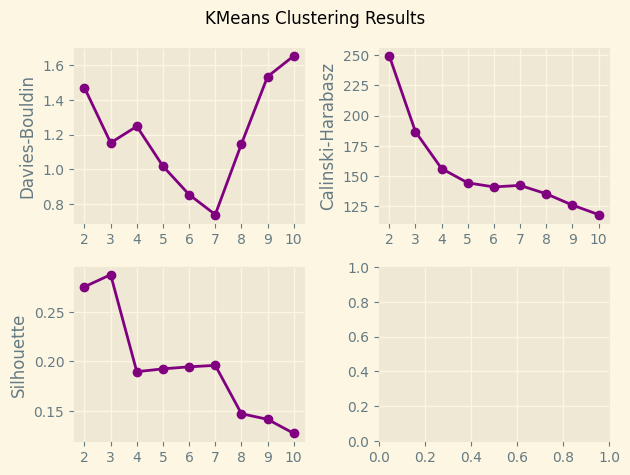

In [143]:
test_clustering(econ, weights=econ_weights.sparse)

Based on this, anywhere from 5-7 clusters seems viable.

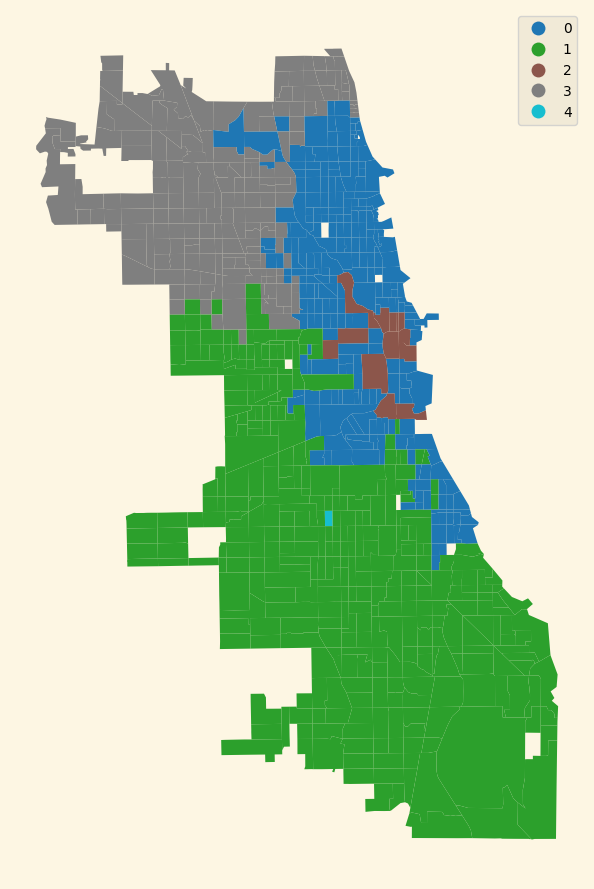

In [144]:
econ = cluster_map(econ, 5, econ_weights.sparse)

5 clusters looks good! Let's see what the summary is:

In [159]:
summarize_clusters(econ)

labels,variable,aggregate,0,1,2,3,4
0,economic_311s,count,246.000000,343.000000,13.000000,176.000000,1.000000
1,economic_311s,mean,-0.063092,0.118192,3.611787,-0.404749,-0.736923
2,economic_311s,std,0.848273,0.935107,1.470354,0.645768,NaN
8,MedInc,mean,-0.068623,0.061850,0.062924,0.062112,-16.083115
9,MedInc,std,1.452840,0.000255,0.000855,0.000292,NaN
15,PovP,mean,-0.571189,0.592886,-0.778181,-0.311215,2.042703
16,PovP,std,0.576250,1.102010,0.461181,0.533657,NaN
22,Unemployment,mean,-0.617321,0.714932,-0.604132,-0.487774,0.341302
23,Unemployment,std,0.471577,1.049168,0.508540,0.408165,NaN
29,HighRiskJobP,mean,-0.784988,0.436310,-0.934193,0.314969,0.162831


**Cluster 0:** Below mean povety, below mean unemployment, below mean high risk jobs, and below mean households without internet; this is an affluent cluster. It's also on the lake, so maybe "Lakeshore Affluent" works as a name.

**Cluster 1:** Slightly above economic 311s, average median income, above average poverty, unemployment, high risk work, and bleow average internet access. This is a poorer cluster, and it's also on the South and West sides, so maybe "Southwest Poorer"?

**Cluster 2:** This cluster has a massive number of economic 311s in comparison to the others, and is typically employed in safe jobs with internet and low poverty. Based on location, let's call this "Downtown Affluent".

**Cluster 3:** This cluster has below average 311s, below average poverty and unemployment, but slightly above average jobs. That seems to mark it as a "North Side Middle Class" 

**Cluster 4:** This is a single member cluster, so we both decline to name it and drop it from future analyses.

We save our clusters and move onto the next batch!

In [185]:
rename_dct = {
    0:'Lakeshore Affluent',
    1:'Southwest Poorer',
    2:'Downtown Affluent',
    3:'Northside Middle Class',
    4:'SINGLETON'
}

econ['labels'] = econ['labels'].apply(lambda x: rename_dct[x])

econ.to_file('../data/envi_clusters/econ_clusters.geojson')

#### Social

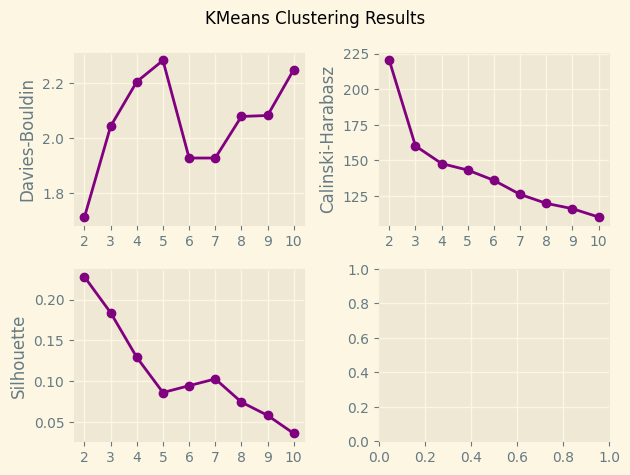

In [176]:
test_clustering(social, weights=social_weights.sparse)

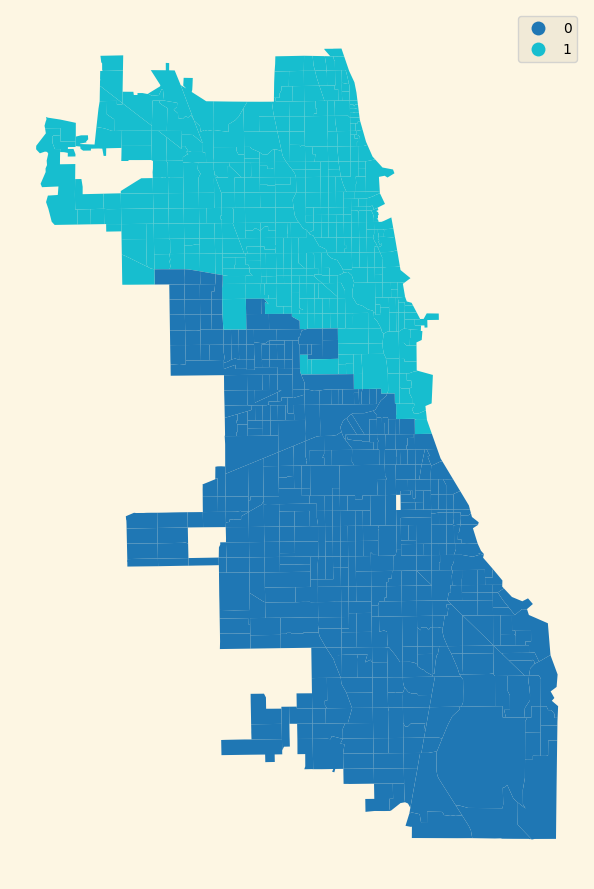

In [107]:
cluster_map(social, 2, social_weights.sparse)

In [175]:
summarize_clusters(social)

labels,variable,aggregate,0,1
0,social_311s,count,427.000000,361.000000
1,social_311s,mean,0.102311,-0.121017
2,social_311s,std,1.095017,0.861914
8,MHSdP,mean,0.518161,-0.612894
9,MHSdP,std,0.816733,0.839286
15,RPL_THEMES,mean,0.519361,-0.614314
16,RPL_THEMES,std,0.651082,0.994433
22,violent_crime_rate,mean,0.435141,-0.514696
23,violent_crime_rate,std,1.077256,0.570454
29,WhiteP,mean,-0.678908,0.803029


These clusters are, tragically, what one would probably expect based on the map. We have "white and socially organized\*" versus "not white, socially disorganized\*". We'll call them "Northside" and "Southwestside"

\*the specific language from prior literature

In [192]:
rename_dct = {
    1: 'Northside',
    0: 'Southwestside'
}

social['labels'] = social['labels'].apply(lambda x: rename_dct[x])
social.to_file('../data/envi_clusters/social.geojson')

#### Physical

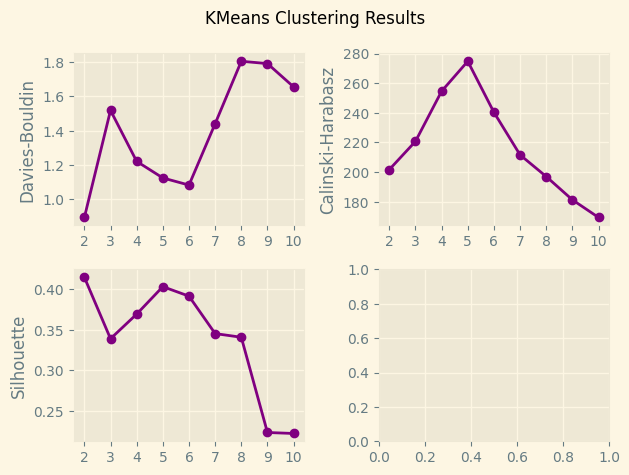

In [111]:
test_clustering(physical, weights=physical_weights.sparse)

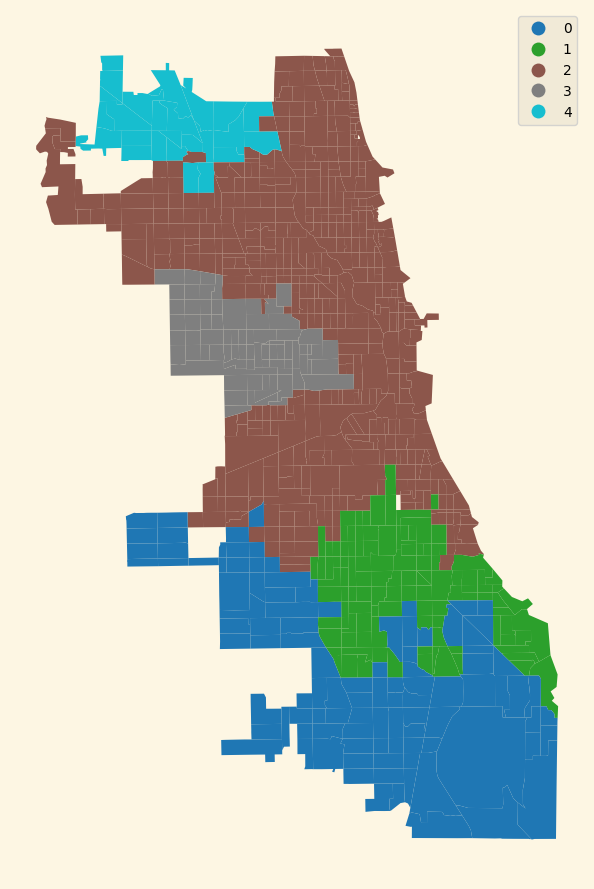

In [112]:
cluster_map(physical, 5, physical_weights.sparse)

In [181]:
summarize_clusters(physical)

labels,variable,aggregate,0,1,2,3,4
0,physical_311s,count,103.000000,111.000000,474.000000,74.000000,25.000000
1,physical_311s,mean,0.763605,0.899113,-0.523831,0.904551,0.116253
2,physical_311s,std,0.892190,1.188367,0.584615,0.789216,0.328736
8,relative_greenery,mean,1.296200,-0.039867,-0.379595,-0.134044,2.430560
9,relative_greenery,std,1.049913,0.582570,0.581780,0.618486,1.563396
15,VacantP,mean,-0.176893,1.338811,-0.329224,0.533049,-0.551268
16,VacantP,std,1.052907,1.148592,0.606477,0.945020,0.557209


Naming time!

**Cluster 0:** Above average physical 311s, below average vacancy, and above average greenery -- "Southside Greenery"?

**Cluster 1:** Middling greenery, above average vacancies and physical 311s -- "Vacant Needs Repairs"?

**Cluster 2:** Below average 311s, below average greenery, and below average vacancy. "Standard Cityscape"?

**Cluster 3:** Above average 311s, below average greenery, above average vacancy, but the actual cluster itself is tighter. Maybe "Disinvested Cityscape?"

**Cluster 4:** Above average greenery, middling 311s, below average vacancy -- "Northside Greenery"?


We'll run with these names for now and save!

In [189]:
rename_dct = {
    0:'Southside Greenery',
    1:'Vacant Needs Repairs',
    2:'Standard Cityscape',
    3:'Disinvested Cityscape',
    4:'Northside Greenery',
}

physical['labels'] = physical['labels'].apply(rename_dct.get)
physical.to_file('../data/envi_clusters/physical.geojson')

#### Political

c:\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:304: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
c:\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:304: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
c:\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:304: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
c:\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:304: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connec

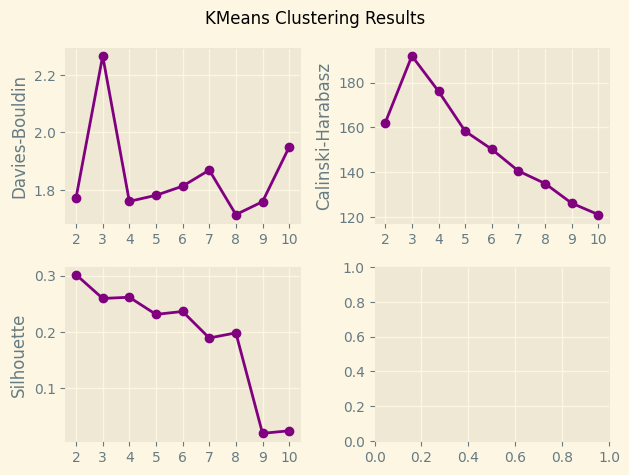

In [113]:
test_clustering(policy, weights=policy_weights.sparse)

c:\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:304: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


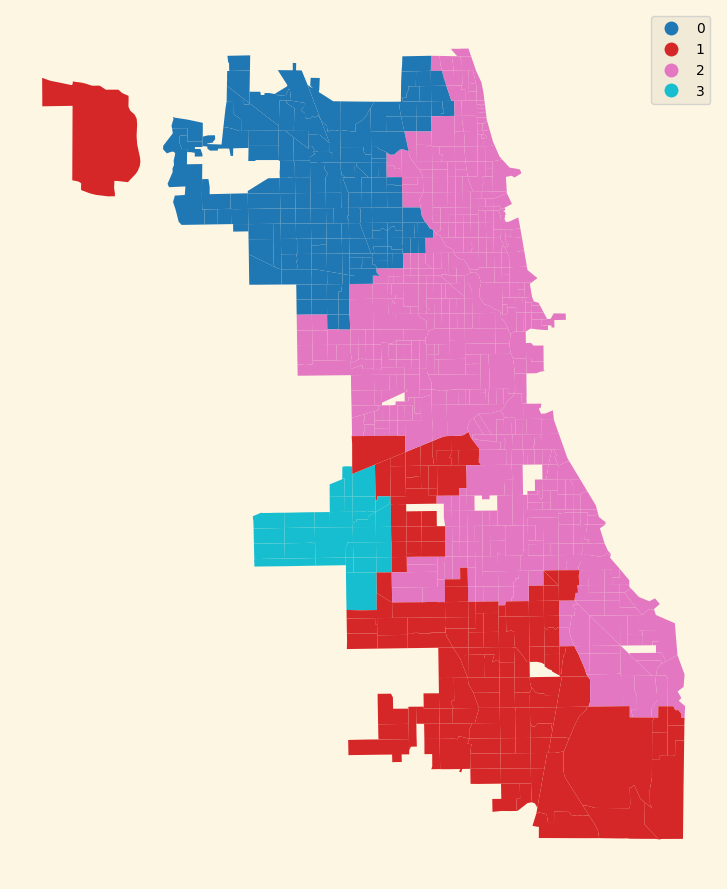

In [115]:
cluster_map(policy, 4, policy_weights.sparse)

In [191]:
summarize_clusters(policy, relevant_aggs=['count', 'mean'])

labels,variable,aggregate,0,1,2,3
0,minDisHosp,count,144.000000,130.000000,474.000000,31.000000
1,minDisHosp,mean,0.118775,0.870950,-0.420419,2.224244
8,metMinDis,mean,1.043073,-0.025070,-0.427429,1.795423
15,bupMinDis,mean,0.228817,1.215532,-0.428972,0.398839
22,minDist_OTP,mean,0.940133,-0.074822,-0.414950,2.291411
29,minDisMH,mean,0.499772,0.732252,-0.427995,1.151923


**Cluster 0:** __Middling Medical Access__

**Cluster 1:** __Great OTP and Methadone Access__

**Cluster 2:** __Great Medical Access__

**Cluster 3:** __Worst Medical Access__

This feels like sufficient reason to cut these from the analysis -- clustering drive distances is seemingly not a great way to understand the political environment.